# Good Software - analysis notebook
## Reproducing all panels from Figure 1

<br />
This notebook contains all Python code necessary to reproduce all panels from the Figure 1 of [our paper](./), starting from the raw dataset. If you are interested in reproducing our results, you can use Binder to get started immediately (no requirements). For more information, visit [our wiki page](./).

**Github:** https://github.com/smangul1/good.software/wiki

**Manuscript:** https://www.biorxiv.org/content/early/2018/10/25/452532

**Twitter thread:** https://twitter.com/serghei_mangul/status/1055561147431043072

### Importing libraries

In [1]:
import pylab as pl
import numpy as np
import pandas as pd

### Some definitions

In [63]:
# Legend for link statuses
legendStatus = { -1 : 'Time out', 1 : 'Accessible', 3 : 'Redirected', 4 : 'Broken' }

# Colors for each status
colors = { -1 : (0.96,0.65,0.51), 1 : (0.57,0.77,0.87), 3 : (0.02,0.44,0.69), 4 : (0.8,0.,0.13) }

# Scheme 2:
colors2 = { 'bg_unreach' : (1.0,0.8,0.6), 
            'fg_unreach' : (0.8,0.,0.), 
            'bg_accessb' : (0.7,1.0,0.7), 
            'fg_accessb' : (0.0,0.0,0.8)
         }

# Will only consider these years
initialYear = 2005

### Util functions

In [3]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Importing and parsing data

In [4]:
links = pd.read_csv('links.bulk.csv')
links.head()

,type,journal,id,year,link,code,flag.uniqueness
0,abstract,Nucleic_Acids_Res,23155066.0,2013,http://www.netlab.uky.edu/p/bioinfo/DiffSplice,200,0
1,abstract,Bioinformatics,27273673.0,2017,http://www.cs.helsinki.fi/u/lmsalmel/LoRMA/,302,0
2,abstract,BMC_Bioinformatics,20492656.0,2010,http://www.cse.univdhaka.edu/~ashis/ppred/inde...,301,0
3,abstract,PLoS_Comput_Biol,28212402.0,2017,https://dongjunchung.github.io/GGPA/,301,0
4,abstract,Bioinformatics,28130230.0,2017,https://github.com/bfosso/MetaShot,301,0


In [5]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48392 entries, 0 to 48391
Data columns (total 7 columns):
type               48392 non-null object
journal            48392 non-null object
id                 48093 non-null float64
year               48392 non-null int64
link               48392 non-null object
code               48392 non-null int64
flag.uniqueness    48392 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 2.6+ MB


Parsing from code into human-readable status:

* -1 : time out
* 0..299 : good
* 300..399 : redirected
* \>= 400 : not found

To make it easier, let's map these codes to -1 for time out, 1 for accessible, 3 for redirected, and 4 for not found.

In [6]:
links = links[ links.year >= initialYear ]
links['status'] = ( links['code'] // 100 )
links.loc[ links['status'] > 4, 'status' ] = 4
links.loc[ (links['status'] >= 0) & (links['status'] < 3), 'status' ] = 1

Let's look at the histogram of statuses

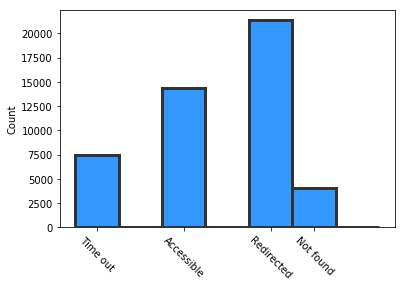

In [7]:
statuses = np.array( links.status )


f, ax = pl.subplots(1, 1)
ax.hist( statuses, np.arange(-1.5,6,1), edgecolor=(0.2,0.2,0.2), lw=3, 
            color=(0.2,0.6,1.0) )


ax.set_ylabel('Count')
ax.set_xticks([-1, 1, 3, 4])
ax.set_xticklabels( ['Time out', 'Accessible', 'Redirected', 'Not found'], rotation=-45 )

pl.show()

In [8]:
count, bin_values = np.histogram(statuses, bins = [-1.2,-0.8,1.8,3.8,4.8])

print(count, bin_values)
total = float(count.sum())

for j in range(4):
    print(count[j]/total)

[ 7487 14394 21355  4039] [-1.2 -0.8  1.8  3.8  4.8]
0.15837123215230037
0.30447382337387624
0.451718667371761
0.0854362771020624


### Filtering out repeated links

To avoid using repeated links, let's create another dataframe.

In [9]:
uniqueLinks = links[ links['flag.uniqueness'] == 0 ]
print(uniqueLinks.shape)
uniqueLinks = uniqueLinks.drop(columns=['flag.uniqueness'])
uniqueLinks.head()

(36702, 8)


,type,journal,id,year,link,code,status
0,abstract,Nucleic_Acids_Res,23155066.0,2013,http://www.netlab.uky.edu/p/bioinfo/DiffSplice,200,1
1,abstract,Bioinformatics,27273673.0,2017,http://www.cs.helsinki.fi/u/lmsalmel/LoRMA/,302,3
2,abstract,BMC_Bioinformatics,20492656.0,2010,http://www.cse.univdhaka.edu/~ashis/ppred/inde...,301,3
3,abstract,PLoS_Comput_Biol,28212402.0,2017,https://dongjunchung.github.io/GGPA/,301,3
4,abstract,Bioinformatics,28130230.0,2017,https://github.com/bfosso/MetaShot,301,3


In [10]:
repeated_data = pd.concat(g for _, g in uniqueLinks.groupby("id") if len(g) > 1)
repeated_data.head(15)

,type,journal,id,year,link,code,status
1516,abstract,Nucleic_Acids_Res,15608157.0,2005,http://www.human-siRNA-database.net,301,3
25875,body,Nucleic_Acids_Res,15608157.0,2005,www.human-siRNA-database.net,-1,-1
1771,abstract,Nucleic_Acids_Res,15608160.0,2005,http://rfam.wustl.edu/,-1,-1
3406,abstract,Nucleic_Acids_Res,15608160.0,2005,http://www.sanger.ac.uk/Software/Rfam/,301,3
11997,body,Nucleic_Acids_Res,15608160.0,2005,http://infernal.wustl.edu/,-1,-1
2859,abstract,Nucleic_Acids_Res,15608162.0,2005,http://siRNA.cgb.ki.se,301,3
18563,body,Nucleic_Acids_Res,15608162.0,2005,http://aosearch.cgb.ki.se,-1,-1
3097,abstract,Nucleic_Acids_Res,15608164.0,2005,http://alpha.protres.ru/trnadbase,-1,-1
4575,abstract,Nucleic_Acids_Res,15608164.0,2005,http://www.tRNA.uni-bayreuth.de,200,1
7689,abstract,Nucleic_Acids_Res,15608166.0,2005,http://www.cs.ualberta.ca/~bioinfo/PA/GOSUB,301,3


In [11]:
uniqueLinks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36702 entries, 0 to 48391
Data columns (total 7 columns):
type       36702 non-null object
journal    36702 non-null object
id         36536 non-null float64
year       36702 non-null int64
link       36702 non-null object
code       36702 non-null int64
status     36702 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 2.2+ MB


In [12]:
uniqueLinks.describe()

,id,year,code,status
count,3.653600e+04,36702.000000,36702.000000,36702.000000
mean,2.282358e+07,2012.014332,232.363413,1.849981
std,3.722272e+06,3.483438,120.649623,1.603584
min,1.560816e+07,2005.000000,-1.000000,-1.000000
25%,1.978383e+07,2009.000000,200.000000,1.000000
50%,2.318078e+07,2012.000000,301.000000,3.000000
75%,2.595065e+07,2015.000000,301.000000,3.000000
max,2.916934e+07,2017.000000,999.000000,4.000000


In [13]:
print( 'Percent of repeated links: %.1f%%' % ( (1 - len(uniqueLinks)/len(links))*100. ) )

Percent of repeated links: 22.4%


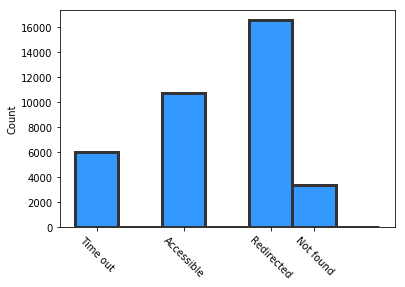

In [14]:
statuses = np.array( uniqueLinks.status )

f, ax = pl.subplots(1, 1)
ax.hist( statuses, np.arange(-1.5,6,1), edgecolor=(0.2,0.2,0.2), lw=3, 
            color=(0.2,0.6,1.0) )


ax.set_ylabel('Count')
ax.set_xticks([-1, 1, 3, 4])
ax.set_xticklabels( ['Time out', 'Accessible', 'Redirected', 'Not found'], rotation=-45 )

pl.show()

In [15]:
np.unique(uniqueLinks.id).shape

(19209,)

## Fixing http -> https redirection

Due to increased security awareness in the past few years, a number of links marked as redirections are in fact just changing the http protocol to https. We will not consider them as redirection, if the rest of the URL is the same.

In [16]:
redirection_checking = pd.read_csv('http2https.redirected.csv', 
                                    header=None, names=['pubmed_id', 'url', 'status', 'https_redirect']
                                  )
redirection_checking.head(10)

,pubmed_id,url,status,https_redirect
0,27273673,http://www.cs.helsinki.fi/u/lmsalmel/LoRMA/,302,True
1,20492656,http://www.cse.univdhaka.edu/~ashis/ppred/inde...,301,-1
2,28212402,https://dongjunchung.github.io/GGPA/,301,True
3,28130230,https://github.com/bfosso/MetaShot,301,True
4,20935049,http://github.com,301,False
5,21765097,http://nwrce.org/pgat,301,False
6,17939871,http://kdbio.inesc-id.pt/~svinga/ep/,301,False
7,28453681,http://opig.stats.ox.ac.uk/webapps/sphinx,301,False
8,21546392,http://www.microbio.me/boulderale,301,-1
9,22034521,http://www.cmbi.ru.nl/pdb_redo,302,False


In [17]:
for index, row in redirection_checking.iterrows():
    if row['https_redirect'] == 'True' and uniqueLinks[ uniqueLinks.link == row['url']].shape[0] > 0:
        idx = np.where(uniqueLinks.link == row['url'])[0][0]
        uniqueLinks.iloc[idx,6] = 1

In [18]:
uniqueLinks.head()

,type,journal,id,year,link,code,status
0,abstract,Nucleic_Acids_Res,23155066.0,2013,http://www.netlab.uky.edu/p/bioinfo/DiffSplice,200,1
1,abstract,Bioinformatics,27273673.0,2017,http://www.cs.helsinki.fi/u/lmsalmel/LoRMA/,302,1
2,abstract,BMC_Bioinformatics,20492656.0,2010,http://www.cse.univdhaka.edu/~ashis/ppred/inde...,301,3
3,abstract,PLoS_Comput_Biol,28212402.0,2017,https://dongjunchung.github.io/GGPA/,301,1
4,abstract,Bioinformatics,28130230.0,2017,https://github.com/bfosso/MetaShot,301,1


In [19]:
statuses = uniqueLinks.status
count, bin_values = np.histogram(statuses, bins = [-1.2,-0.8,1.8,3.8,4.8])

print(count, bin_values)
total = float(count.sum())

for j in range(4):
    print(count[j]/total)

[ 6036 10926 16336  3404] [-1.2 -0.8  1.8  3.8  4.8]
0.16445970246853034
0.2976949485041687
0.44509835976241074
0.0927469892648902


In [20]:
(count[0]+count[-1])/total

0.25720669173342053

## Constructing a dataframe with only abstracts

In [21]:
uniqueLinks_abs = uniqueLinks[ uniqueLinks.type == 'abstract' ]
uniqueLinks_abs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7183 entries, 0 to 7877
Data columns (total 7 columns):
type       7183 non-null object
journal    7183 non-null object
id         7182 non-null float64
year       7183 non-null int64
link       7183 non-null object
code       7183 non-null int64
status     7183 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 448.9+ KB


## Number of entries per journal

Next, let's evaluate the number of entries detected per journal.

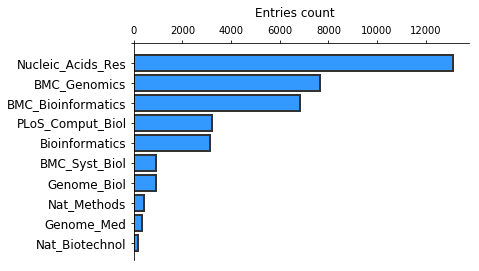

Journal name 		 Count
Nat_Biotechnol		 180
Genome_Med		 352
Nat_Methods		 403
Genome_Biol		 904
BMC_Syst_Biol		 912
Bioinformatics		 3131
PLoS_Comput_Bio		 3226
BMC_Bioinformat		 6840
BMC_Genomics		 7651
Nucleic_Acids_R		 13103


In [22]:
journals = np.array( uniqueLinks.journal )
journalTitles = np.unique(journals)

jhash = {}
for jid,journal in enumerate(journalTitles):
    jhash[journal] = jid
listxs = np.arange(0,11,1)

journals_num = [ jhash[journal] for journal in journals ]

counts, bins = np.histogram( journals_num, bins=listxs )

newIDX = np.argsort(counts)

f, ax = pl.subplots(1, 1)
ax.barh( bins[0:-1], counts[newIDX], 0.8, edgecolor=(0.2,0.2,0.2), lw=2, 
            color=(0.2,0.6,1.0) )

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_top()
ax.get_yaxis().tick_left()

ax.text( 5000, 11.3, 'Entries count', fontsize=12 )

ax.set_yticks( listxs )
ax.set_yticklabels( journalTitles[newIDX], rotation=0, fontsize=12 )

pl.show()

print('Journal name \t\t Count')
for jid,journal in enumerate(journalTitles[newIDX]):
    print('%s\t\t %d' %(journal[:15],counts[newIDX][jid]) )

Let's also detect how many of them were usable (i.e. accessible or redirected).

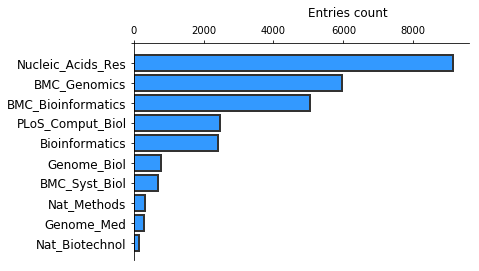

Journal name 		 Count
Nat_Biotechnol		 144
Genome_Med		 306
Nat_Methods		 320
BMC_Syst_Biol		 682
Genome_Biol		 780
Bioinformatics		 2409
PLoS_Comput_Bio		 2473
BMC_Bioinformat		 5051
BMC_Genomics		 5970
Nucleic_Acids_R		 9127


In [23]:
usable_links = uniqueLinks[(uniqueLinks.status == 1) | (uniqueLinks.status == 3)]
journals = np.array( usable_links.journal )
journalTitles = np.unique(journals)

jhash = {}
for jid,journal in enumerate(journalTitles):
    jhash[journal] = jid
listxs = np.arange(0,11,1)

journals_num = [ jhash[journal] for journal in journals ]

counts, bins = np.histogram( journals_num, bins=listxs )

newIDX = np.argsort(counts)

f, ax = pl.subplots(1, 1)
ax.barh( bins[0:-1], counts[newIDX], 0.8, edgecolor=(0.2,0.2,0.2), lw=2, 
            color=(0.2,0.6,1.0) )

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_top()
ax.get_yaxis().tick_left()

ax.text( 5000, 11.3, 'Entries count', fontsize=12 )

ax.set_yticks( listxs )
ax.set_yticklabels( journalTitles[newIDX], rotation=0, fontsize=12 )

pl.show()

print('Journal name \t\t Count')
for jid,journal in enumerate(journalTitles[newIDX]):
    print('%s\t\t %d' %(journal[:15],counts[newIDX][jid]) )

## Number of entries per abstract

Same for the number of abstracts

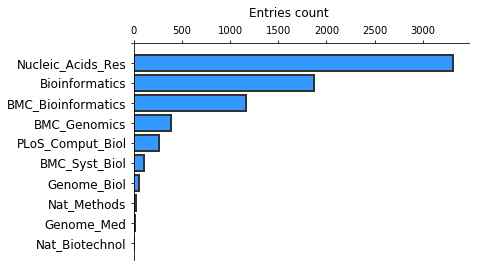

Journal name 		 Count
Nat_Biotechnol		 1
Genome_Med		 18
Nat_Methods		 20
Genome_Biol		 60
BMC_Syst_Biol		 104
PLoS_Comput_Bio		 259
BMC_Genomics		 386
BMC_Bioinformat		 1161
Bioinformatics		 1866
Nucleic_Acids_R		 3308


In [24]:
journals = np.array( uniqueLinks_abs.journal )
journalTitles = np.unique(journals)

jhash = {}
for jid,journal in enumerate(journalTitles):
    jhash[journal] = jid
listxs = np.arange(0,11,1)

journals_num = [ jhash[journal] for journal in journals ]

counts, bins = np.histogram( journals_num, bins=listxs )

newIDX = np.argsort(counts)

f, ax = pl.subplots(1, 1)
ax.barh( bins[0:-1], counts[newIDX], 0.8, edgecolor=(0.2,0.2,0.2), lw=2, 
            color=(0.2,0.6,1.0) )

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_top()
ax.get_yaxis().tick_left()

ax.text( 1200, 11.3, 'Entries count', fontsize=12 )

ax.set_yticks( listxs )
ax.set_yticklabels( journalTitles[newIDX], rotation=0, fontsize=12 )

pl.show()

print('Journal name \t\t Count')
for jid,journal in enumerate(journalTitles[newIDX]):
    print('%s\t\t %d' %(journal[:15],counts[newIDX][jid]) )

## Number of of links per year

In [25]:
uLinks_year = uniqueLinks.groupby(['year', 'status']).agg('count')

In [26]:
uLinks_year.head(12)

type  journal   id  link  code
year status                                
2005 -1       462      462  461   462   462
      1       319      319  318   319   319
      3       549      549  535   549   549
      4       235      235  233   235   235
2006 -1       442      442  435   442   442
      1       333      333  333   333   333
      3       591      591  585   591   591
      4       216      216  212   216   216
2007 -1       468      468  466   468   468
      1       340      340  335   340   340
      3       603      603  588   603   603
      4       230      230  230   230   230

Grouping by status and retrieving the percent for each status per year.

In [27]:
tseries = {}
for j,status in enumerate([-1, 1, 3, 4]):
    tseries[status] = np.array( uLinks_year.iloc[j::4].link )

Plotting

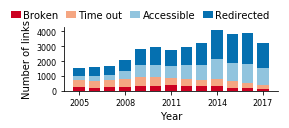

In [34]:
barsize=0.75

f, ax = pl.subplots(1, 1, figsize=(4,2.2) )

b = np.zeros( tseries[status].shape[0] )
years = np.arange(2005,2018,1)

for zlabel,status in enumerate([4,-1,1,3]):
    ax.bar( years, tseries[status] + b, barsize, label=legendStatus[status], 
               color=colors[status], zorder=-1-zlabel )
    b += tseries[status]

simpleaxis(ax)

ax.set_ylabel("Number of links")
ax.set_yticks( np.arange(0,4001,1000) )
ax.set_yticklabels( np.array( np.arange(0,4001,1000), dtype=int ), fontsize=8 )

ax.set_xlabel("Year")
ax.set_xticks( np.arange( 2005,2020,3 ) )
ax.set_xticklabels( np.arange( 2005,2020,3 ), fontsize=8 )

pl.legend(bbox_to_anchor=(1,1.4), frameon=False, ncol=4, 
          handletextpad=0.2, columnspacing=0.8, handlelength=1)

pl.tight_layout()
pl.savefig('Figure_1_panels/NumLinks per year - all.pdf')

## Percent of links per year

Normalizing the number of links for each year.

In [35]:
tseries_norm = np.zeros( tseries[-1].shape )
for status in [-1, 1, 3, 4]:
    tseries_norm += tseries[status]

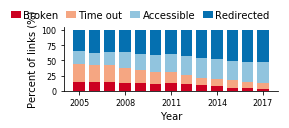

In [36]:
barsize=0.75

f, ax = pl.subplots(1, 1, figsize=(4,2.2) )

b = np.zeros( tseries[status].shape[0] )
years = np.arange(2005,2018,1)

for zlabel,status in enumerate([4,-1,1,3]):
    ax.bar( years, ( tseries[status]/tseries_norm + b )*100., 
               barsize, label=legendStatus[status], 
               color=colors[status], zorder=-1-zlabel )
    b += tseries[status]/tseries_norm

simpleaxis(ax)

ax.set_ylabel("Percent of links (%)")
ax.set_yticks( np.arange(0,101,25) )
ax.set_yticklabels( np.array( np.arange(0,101,25), dtype=int ), fontsize=8 )

ax.set_xlabel("Year")
ax.set_xticks( np.arange( 2005,2020,3 ) )
ax.set_xticklabels( np.arange( 2005,2020,3 ), fontsize=8 )

pl.legend(bbox_to_anchor=(1,1.4), frameon=False, ncol=4, 
          handletextpad=0.2, columnspacing=0.8, handlelength=1)

pl.tight_layout()
pl.savefig('Figure_1_panels/Percent per year - all.pdf')

## Number of links as function of time

Counting total number per year

Plotting:

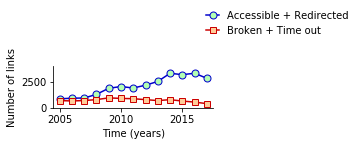

In [37]:
f, ax = pl.subplots( 1, 1, figsize=(3.4, 2.) )

pl.plot( years, tseries[1] + tseries[3], 'o-', 
            markersize=7, label='Accessible + Redirected', color=colors2['fg_accessb'],
            markeredgecolor=colors2['fg_accessb'], markerfacecolor=colors2['bg_accessb'] )
pl.plot( years, tseries[-1] + tseries[4], 's-', 
            markersize=6, label='Broken + Time out', color=colors2['fg_unreach'],
            markeredgecolor=colors2['fg_unreach'], markerfacecolor=colors2['bg_unreach'] )

simpleaxis(ax)

pl.ylabel('Number of links')
pl.ylim(0,4050)

pl.xlabel('Time (years)')
pl.xlim(2004.5,2017.5)

pl.legend(bbox_to_anchor=(0.9,1.5), frameon=False, handlelength=1.3)

pl.tight_layout()
pl.savefig('Figure_1_panels/Total per year - all.pdf')

Ratio between accessible links in 2017 in reference to that in 2005

In [38]:
numAccessible = tseries[1] + tseries[3]

ratio = numAccessible[-1] / numAccessible[0]
print('Ratio: %.2f' % ratio)

avgGrowthRatio = (numAccessible[-1] - numAccessible[0]) / (2017-2005) / numAccessible[0]
print( 'Average growth ratio: %.1f%%' % (avgGrowthRatio*100) )

Ratio: 3.27
Average growth ratio: 18.9%


Ratio between unreachable links in 2017 in reference to that in 2005

In [39]:
numUnreachable = tseries[-1] + tseries[4]

ratio = numUnreachable[-1] / numUnreachable[0]
print('Ratio: %.2f' % ratio)


avgGrowthRatio = (numUnreachable[-1] - numUnreachable[0]) / (2017-2005) / numUnreachable[0]
print( 'Average growth ratio: %.1f%%' % (avgGrowthRatio*100) )

Ratio: 0.58
Average growth ratio: -3.5%


# Parsing Github and SourceForge

In [40]:
def count_status(statuses):
    count, bin_values = np.histogram(statuses, bins = [-1.2,-0.8,1.8,3.8,4.8])

    print(count, bin_values)
    total = float(count.sum())

    for j in range(4):
        print(count[j]/total)

In [41]:
find_github = lambda x: 'github.com' in x.link
find_sourceforge = lambda x: 'sourceforge.net' in x.link
find_others = lambda x: ('github.com' not in x.link) and ('sourceforge.net' not in x.link)

uniqLabs_github = uniqueLinks_abs[ uniqueLinks_abs.apply(find_github, axis=1) ]
uniqLabs_sourceforge = uniqueLinks_abs[ uniqueLinks_abs.apply(find_sourceforge, axis=1) ]
uniqLabs_others = uniqueLinks_abs[ uniqueLinks_abs.apply(find_others, axis=1) ]

count_status(uniqLabs_github.status)
count_status(uniqLabs_sourceforge.status)
count_status(uniqLabs_others.status)

[  3  98 252   0] [-1.2 -0.8  1.8  3.8  4.8]
0.0084985835694051
0.2776203966005666
0.7138810198300283
0.0
[  1 107 105   1] [-1.2 -0.8  1.8  3.8  4.8]
0.004672897196261682
0.5
0.49065420560747663
0.004672897196261682
[1166 2466 2400  584] [-1.2 -0.8  1.8  3.8  4.8]
0.17623941958887546
0.37273276904474
0.36275695284159615
0.08827085852478839


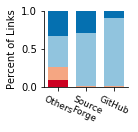

In [44]:
f, ax = pl.subplots( 1, 1, figsize=(1.5, 1.4) )

# let's make sure the order is maintained:
data_broken = np.array([0.08827085852478839, 0.004672897196261682,0])
data_timeout = np.array([0.17623941958887546, 0.004672897196261682, 0.0084985835694051])
data_accessible = np.array([0.4068923821039903, 0.7009345794392523, 0.9036827195467422])
data_redirected = np.array([0.32859733978234584, 0.2897196261682243, 0.08781869688385269])

pl.bar( [0,1,2], data_broken+data_timeout+data_accessible+data_redirected, 0.7, color=colors[3], lw=1.3, capsize=8 )
pl.bar( [0,1,2], data_broken+data_timeout+data_accessible, 0.7, color=colors[1], lw=1.3, capsize=8 )
pl.bar( [0,1,2], data_broken+data_timeout, 0.7, color=colors[-1], lw=1.3, capsize=8 )
pl.bar( [0,1,2], data_broken, 0.7, color=colors[4], lw=1.3, capsize=8 )

ax.set_ylim(0,1)
ax.set_ylabel('Percent of Links')

ax.set_xlabel('')
ax.set_xlim(-0.5,2.5)
ax.set_xticks([0,1,2])
ax.set_xticklabels( ['Others','Source\nForge','GitHub'], 
                       rotation=-25, fontsize=9)

simpleaxis(ax)

pl.savefig('Figure_1_panels/Percent - github sourceforge.pdf')

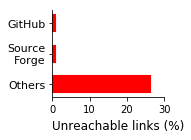

In [45]:
f, ax = pl.subplots(1, 1, figsize=(2.,1.6))

data_broken = np.array([0.08827085852478839, 0.004672897196261682,0])*100
data_timeout = np.array([0.17623941958887546, 0.004672897196261682, 0.0084985835694051])*100

data_unreachable = data_broken + data_timeout

ax.barh( [0,1,2], data_unreachable, 0.6, edgecolor=(1.0,0.0,0.0), lw=0.1, color=(1.0,0.0,0.0) )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.text( -0.05, -1.5, 'Unreachable links (%)', fontsize=12 )

ax.set_xticks( [0, 10, 20, 30] )
ax.set_yticks( [0, 1, 2] )
ax.set_yticklabels( ['Others', 'Source\nForge', 'GitHub'], rotation=0, fontsize=11 )

pl.savefig('Figure_1_panels/Percent - github sourceforge_I.pdf')

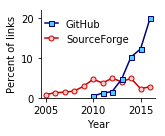

In [46]:
uniqLabs_github = uniqueLinks_abs[ uniqueLinks_abs.apply(find_github, axis=1) ]

tseries_norm = uniqueLinks_abs.groupby(['year']).agg('count').type
tseries_GH = uniqLabs_github.groupby(['year']).agg('count').type[:-1]/tseries_norm[5:-1]*100
years_gh = range(2010,2017)
tseries_SF = uniqLabs_sourceforge.groupby(['year']).agg('count').type/tseries_norm[:-1]*100
years_sf = range(2005,2017)

f, ax = pl.subplots( 1, 1, figsize=(2.4, 2.) )

gh_color=(0.0,0.0,0.5)
gh_incolor=(0.3,0.8,1.0)
pl.plot( years_gh, tseries_GH, 's-', zorder=2,
            markersize=5, label='GitHub', color=gh_color,
            markeredgecolor=gh_color, markerfacecolor=gh_incolor )

sf_color=(0.8,0.0,0.0)
sf_incolor=(1.0,0.8,0.8)
pl.plot( years_sf, tseries_SF, 'o-', zorder=1,
            markersize=5, label='SourceForge', color=sf_color,
            markeredgecolor=sf_color, markerfacecolor=sf_incolor )

simpleaxis(ax)

pl.ylabel('Percent of links')
pl.ylim(0,22)
ax.set_xticks([2005, 2010, 2015])

pl.xlabel('Year')
pl.xlim(2004.5,2016.5)

pl.legend(bbox_to_anchor=(0.85,1.), frameon=False, handlelength=1.3, fontsize=10)

pl.tight_layout()
pl.savefig('Figure_1_panels/Total per year - github.pdf')

## Number of links per year - abstract only

In [47]:
uLinks_ya = uniqueLinks_abs.groupby(['year', 'status']).agg('count')

tseries_abs = {}
for j,status in enumerate([-1, 1, 3, 4]):
    tseries_abs[status] = np.array( uLinks_ya.iloc[j::4].link )

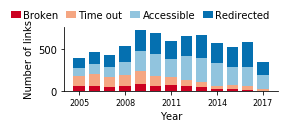

In [48]:
barsize=0.75

f, ax = pl.subplots(1, 1, figsize=(4,2.2) )

b = np.zeros( tseries_abs[status].shape[0] )
years = np.arange(2005,2018,1)

for zlabel,status in enumerate([4,-1,1,3]):
    ax.bar( years, tseries_abs[status] + b, barsize, label=legendStatus[status], 
               color=colors[status], zorder=-1-zlabel )
    b += tseries_abs[status]

simpleaxis(ax)

ax.set_ylabel("Number of links")
#ax.set_yticks( np.arange(0,2001,500) )
#ax.set_yticklabels( np.array( np.arange(0,2001,500), dtype=int ), fontsize=8 )

ax.set_xlabel("Year")
ax.set_xticks( np.arange( 2005,2020,3 ) )
ax.set_xticklabels( np.arange( 2005,2020,3 ), fontsize=8 )

pl.legend(bbox_to_anchor=(1,1.4), frameon=False, ncol=4, 
          handletextpad=0.2, columnspacing=0.8, handlelength=1)

pl.tight_layout()
pl.savefig('Figure_1_panels/NumLinks per year - Abstract.pdf')

In [49]:
tseries_norm = np.zeros( tseries_abs[-1].shape )
for status in [-1, 1, 3, 4]:
    tseries_norm += tseries_abs[status]

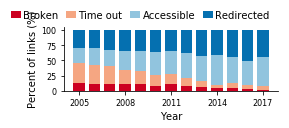

In [50]:
barsize=0.75

f, ax = pl.subplots(1, 1, figsize=(4,2.2) )

b = np.zeros( tseries_abs[status].shape[0] )
years = np.arange(2005,2018,1)

for zlabel,status in enumerate([4,-1,1,3]):
    ax.bar( years, 100*(tseries_abs[status] + b)/tseries_norm, barsize, 
               label=legendStatus[status], 
               color=colors[status], zorder=-1-zlabel )
    b += tseries_abs[status]

simpleaxis(ax)

ax.set_ylabel("Percent of links (%)")
ax.set_yticks( np.arange(0,101,25) )
ax.set_yticklabels( np.array( np.arange(0,101,25), dtype=int ), fontsize=8 )

ax.set_xlabel("Year")
ax.set_xticks( np.arange( 2005,2020,3 ) )
ax.set_xticklabels( np.arange( 2005,2020,3 ), fontsize=8 )

pl.legend(bbox_to_anchor=(1,1.4), frameon=False, ncol=4, 
          handletextpad=0.2, columnspacing=0.8, handlelength=1)

pl.tight_layout()
pl.savefig('Figure_1_panels/Percent per year - Abstract.pdf')

## Status vs IF of current journal 

List of journals considered in this study:

In [51]:
journals = uniqueLinks.journal.unique()
print( journals )

['Nucleic_Acids_Res' 'Bioinformatics' 'BMC_Bioinformatics'
 'PLoS_Comput_Biol' 'BMC_Genomics' 'BMC_Syst_Biol' 'Nat_Biotechnol'
 'Genome_Biol' 'Nat_Methods' 'Genome_Med']


Impact factors were retrieved from this address: http://admin-apps.webofknowledge.com/JCR/JCR?RQ=HOME

In [52]:
IFdata = pd.read_csv('impact_factors_timeseries.csv')
IFdata = IFdata.fillna(0)
IFdata

,year,BMC_Genomics,Nucleic_Acids_Res,Bioinformatics,BMC_Bioinformatics,PLoS_Comput_Biol,Genome_Biol,BMC_Syst_Biol,Nat_Biotechnol,Nat_Methods,Genome_Med
0,2016,3.729,10.162,7.307,2.448,4.542,11.908,2.303,41.667,25.062,7.071
1,2015,3.867,9.202,5.766,2.435,4.587,11.313,2.208,43.113,25.328,5.846
2,2014,3.986,9.112,4.981,2.576,4.620,10.810,2.435,41.514,32.072,5.809
3,2013,4.041,8.808,4.621,2.672,4.829,10.465,2.853,39.080,25.953,4.942
4,2012,4.397,8.278,5.323,3.024,4.867,10.288,2.982,32.438,23.565,3.906
5,2011,4.073,8.026,5.468,2.751,5.215,9.036,3.148,23.268,19.276,0.000
6,2010,4.206,7.836,4.877,3.029,5.515,6.885,3.565,31.090,20.721,0.000
7,2009,3.759,7.479,4.926,3.428,5.759,6.626,4.064,29.495,16.874,0.000
8,2008,3.926,6.878,4.328,3.781,5.895,6.153,3.706,22.297,13.651,0.000
9,2007,4.180,6.954,5.039,3.493,6.236,6.589,0.000,22.848,15.478,0.000


In [53]:
count = {}
Z = np.zeros( (10) )
for status in [1,3,-1,4]:
    count[status] = np.zeros( (10) )

def journalID(journalName): 
    if journalName in journals:
        return np.argwhere(journals == journalName)[0][0]
    else: return -1

for index, row in uniqueLinks.iterrows():
    jid = journalID(row.journal)
    if jid != -1:
        count[row['status']][ jid ] += 1
        Z[ jid ] += 1
    

# Normalizing
for status in [1,3,-1,4]:
    count[status] /= Z

In [54]:
IFs = np.array( IFdata.iloc[0] )[1:]
newIDX = np.argsort( IFs )
IFs = IFs[newIDX]

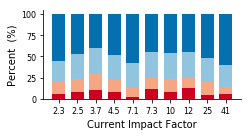

In [55]:
barsize=0.7

f, ax = pl.subplots(1, 1, figsize=(3.6,2.0) )

IFs_x = np.arange(10)

ax.bar( IFs_x, count[4][newIDX], barsize, label='Broken', 
           color=colors[4], zorder=-1 )
b = np.copy( count[4][newIDX] )

ax.bar( IFs_x, b+count[-1][newIDX], barsize, label='Time out', 
           color=colors[-1], zorder=-2 )
b += count[-1][newIDX]

ax.bar( IFs_x, b+count[1][newIDX], barsize, label='Good', 
           color=colors[1], zorder=-3 )
b += count[1][newIDX]

ax.bar( IFs_x, b+count[3][newIDX], barsize, label='Redirect',
           color=colors[3], zorder=-4 )

simpleaxis(ax)

ax.set_ylabel("Percent  (%)")
ax.set_yticks( np.arange(0,1.1,0.25) )
ax.set_yticklabels( np.array( np.arange(0,1.1,0.25)*100, dtype=int ), fontsize=8 )

ax.set_xlabel("Current Impact Factor")
ax.set_xticks( IFs_x )
ax.set_xticklabels( ['2.3','2.5','3.7','4.5','7.1','7.3','10','12','25','41'], 
                       fontsize=8,  )

pl.tight_layout()
pl.savefig('Figure_1_panels/Percent per IF.pdf')

## Status vs IF - abstracts only

List of journals considered in this study:

In [56]:
journals = uniqueLinks_abs.journal.unique()
print( journals )

['Nucleic_Acids_Res' 'Bioinformatics' 'BMC_Bioinformatics'
 'PLoS_Comput_Biol' 'BMC_Genomics' 'BMC_Syst_Biol' 'Nat_Biotechnol'
 'Genome_Biol' 'Nat_Methods' 'Genome_Med']


Impact factors were retrieved from this address: http://admin-apps.webofknowledge.com/JCR/JCR?RQ=HOME

In [57]:
count = {}
Z = np.zeros( (10) )
for status in [1,3,-1,4]:
    count[status] = np.zeros( (10) )

def journalID(journalName): 
    if journalName in journals:
        return np.argwhere(journals == journalName)[0][0]
    else: return -1

for index, row in uniqueLinks_abs.iterrows():
    jid = journalID(row.journal)
    if jid != -1:
        count[row['status']][ jid ] += 1
        Z[ jid ] += 1
    

# Normalizing
for status in [1,3,-1,4]:
    count[status] /= Z

In [58]:
IFs = np.array( IFdata.iloc[0] )[1:]
newIDX = np.argsort( IFs )
IFs = IFs[newIDX]

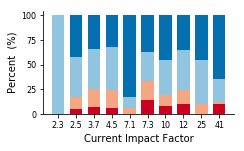

In [59]:
barsize=0.7

f, ax = pl.subplots(1, 1, figsize=(3.5,2.2) )

IFs_x = np.arange(10)

ax.bar( IFs_x, count[4][newIDX], barsize, label='Broken', 
           color=colors[4], zorder=-1 )
b = np.copy( count[4][newIDX] )

ax.bar( IFs_x, b+count[-1][newIDX], barsize, label='Time out', 
           color=colors[-1], zorder=-2 )
b += count[-1][newIDX]

ax.bar( IFs_x, b+count[1][newIDX], barsize, label='Good', 
           color=colors[1], zorder=-3 )
b += count[1][newIDX]

ax.bar( IFs_x, b+count[3][newIDX], barsize, label='Redirect',
           color=colors[3], zorder=-4 )

simpleaxis(ax)

ax.set_ylabel("Percent  (%)")
ax.set_yticks( np.arange(0,1.1,0.25) )
ax.set_yticklabels( np.array( np.arange(0,1.1,0.25)*100, dtype=int ), fontsize=8 )

ax.set_xlabel("Current Impact Factor")
ax.set_xticks( IFs_x )
ax.set_xticklabels( ['2.3','2.5','3.7','4.5','7.1','7.3','10','12','25','41'], 
                       fontsize=8,  )

pl.tight_layout()
pl.savefig('Figure_1_panels/Percent per IF - abstracts.pdf')

## Status vs IF at the time of publication

In [60]:
IFpub = {}
for status in  [1,3,-1,4]:
    IFpub[status] = []

for index, row in uniqueLinks.iterrows():
    year = row.year
    if ( year >= 2003 ) and ( year <= 2017 ) :
        
        # there's no IF for 2017 yet
        if year == 2017: year = 2016
            
        yearIDX = -(year - 2003) + 13
        IF_at_time = IFdata[row.journal].iloc[ yearIDX ]
        IFpub[row.status].append( IF_at_time )

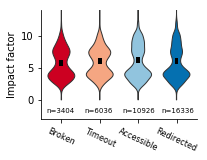

In [67]:
f, ax = pl.subplots( 1, 1, figsize=(2.8, 2.0) )

# let's make sure the order is maintained:
data = [IFpub[4], IFpub[-1], IFpub[1], IFpub[3]]

parts = ax.violinplot( data, [0,1,2,3], showmeans=False, showmedians=False, 
                              showextrema=False, widths=0.7, points=200 )

colors_list = [colors[j] for j in [4, -1, 1, 3]]

j = 0
for pc in parts['bodies']:
    pc.set_facecolor(colors_list[j])
    pc.set_edgecolor( (0.2,0.2,0.2) )
    pc.set_edgecolors( (0.2,0.2,0.2) )
    pc.set_alpha(1)
    j += 1
    

def buttpos(x): return [x-0.05,x+0.05]
for j in range(4):
    pl.plot(buttpos(j), [np.mean(data[j])]*2, color="k", 
                linewidth=6, solid_capstyle="butt", zorder=4)

for j in range(4):
    ax.text( j-0.4, -2, 'n='+str(len(data[j])), fontsize=7 )

ax.set_ylim(-3,14)
ax.set_ylabel('Impact factor')

ax.set_xlabel('')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels( ['Broken','Timeout','Accessible','Redirected'], 
                       rotation=-25, fontsize=8 )

simpleaxis(ax)

pl.savefig('Figure_1_panels/IF vs status.pdf')

In [68]:
from scipy import stats
f_value, p_value = stats.f_oneway(data[0], data[1], data[3], data[2])
print(f_value, p_value)

9.877125130203718 1.659019515265056e-06


## Evolution of IF of each category over the years

In [69]:
IFpub = {}
Z = {}
for status in  [1,3,-1,4]:
    IFpub[status] = np.zeros(12)
    Z[status] = np.zeros(12)

for index, row in uniqueLinks.iterrows():
    year = row.year
    if ( year >= 2003 ) and ( year <= 2017 ) :
        
        # there's no IF for 2017 yet
        if year == 2017: year = 2016
            
        yearIDX = year - 2005
        IF_at_time = IFdata[row.journal].iloc[ yearIDX ]
        IFpub[row.status][yearIDX] += IF_at_time
        Z[row.status][yearIDX] += 1

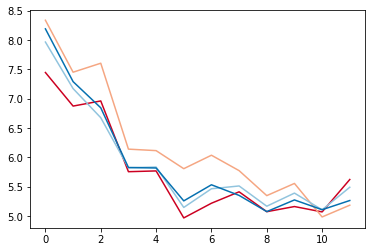

In [70]:
for s in [4,-1,1,3]:
    pl.plot( IFpub[s]/Z[s], color=colors[s] )

## Retrieving altmetric data

In [71]:
def parseAltmetricData(filename):

    parsedData = {}

    inputfile = open( filename, 'r' )

    # skipping first row
    inputfile.readline()

    for line in inputfile:

        lineSplit = line.split('\n')[0].split('[')

        ls_comma  = lineSplit[0].split(',')
        pmid      = int( ls_comma[0] )
        parsedData[pmid] = {}

        score     = float( ls_comma[1] )
        parsedData[pmid]['score'] = score

        numReaders = int( ls_comma[2] )
        parsedData[pmid]['numReaders'] = numReaders

        cited     = int( ls_comma[3] )
        parsedData[pmid]['cited'] = cited

        scopus = lineSplit[1][:-1]
        parsedData[pmid]['scopus'] = scopus

    return parsedData

dictAltmetric = parseAltmetricData('./links.bulk.altmetric.csv')

In [72]:
print( 'Number of Altmetric records: %d ' % (len(dictAltmetric.keys())) )

Number of Altmetric records: 13889 


In [73]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 3  # previous pdf hatch linewidth
from statsmodels.stats.multicomp import MultiComparison

## Altmetric score

In [74]:
scores = {}
for status in  [1,3,-1,4]:
    scores[status] = []

for index, row in uniqueLinks.iterrows():
    if row.id in dictAltmetric.keys():
        numYears = (year - 2003)
        scores[ row.status ].append( dictAltmetric[row.id]['score'] )

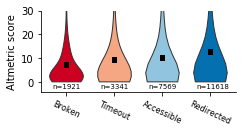

In [75]:
f, ax = pl.subplots( 1, 1, figsize=(3.5, 1.5) )

# let's make sure the order is maintained:
data = [scores[4], scores[-1], scores[1], scores[3]]

parts = ax.violinplot( data, [0,1,2,3], showmeans=False, showmedians=False, 
                              showextrema=False, widths=0.7, points=500 )

j = 0
for pc in parts['bodies']:
    pc.set_facecolor(colors_list[j])
    pc.set_edgecolor( (0.2,0.2,0.2) )
    pc.set_edgecolors( (0.2,0.2,0.2) )
    pc.set_alpha(1)
    j += 1
    

def buttpos(x): return [x-0.05,x+0.05]
for j in range(4):
    pl.plot(buttpos(j), [np.mean(data[j])]*2, color="k", 
                linewidth=6, solid_capstyle="butt", zorder=4)

for j in range(4):
    ax.text( j-0.3, -2.5, 'n='+str(len(data[j])), fontsize=7 )

ax.set_ylim(-4,30)
ax.set_ylabel('Altmetric score')

ax.set_xlabel('')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels( ['Broken','Timeout','Accessible','Redirected'], 
                       rotation=-25, fontsize=8)

simpleaxis(ax)

pl.savefig('Figure_1_panels/Altmetric Score vs status.pdf')

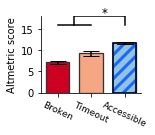

In [76]:
f, ax = pl.subplots( 1, 1, figsize=(1.8, 1.4) )

# let's make sure the order is maintained:
data = [ np.mean(scores[4]), np.mean(scores[-1]), np.mean(scores[1] + scores[3]) ]
vardata = [ np.std(scores[4])/np.sqrt(len(scores[4])), 
           np.std(scores[-1])/np.sqrt(len(scores[-1])), 
           np.std(scores[1] + scores[3])/np.sqrt(len(scores[1] + scores[3])) ]

pl.bar( [0,1,2], data, 0.7, yerr=vardata, color=colors_list, 
           edgecolor=[(0.2,0.2,0.2)]*3, lw=1.3, capsize=8 )

pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color=colors_list[2:], hatch="//",
           edgecolor=[(0.1,0.4,1.0)]*3, lw=1.5, capsize=8 )
pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color='none',
           edgecolor=[(0.0,0.0,0.0)]*3, lw=1.5, capsize=8 )

ax.set_ylabel('Altmetric score')
ax.set_ylim(0,18)
ax.set_yticks([0,5,10,15])

ax.set_xlabel('')
ax.set_xticks([0,1,2])
ax.set_xlim(-0.5,2.5)
ax.set_xticklabels( ['Broken','Timeout','Accessible'], 
                       rotation=-25, fontsize=9)

ax.text(1.3, 18, '*', fontsize=12)
ax.plot([2,2,0.5,0.5], [16,18,18,16], color='k', lw=1.5)
ax.plot([1,0], [16,16], color='k', lw=1.5)

simpleaxis(ax)

pl.savefig('Figure_1_panels/Altmetric Score vs status - barplot.pdf')

In [77]:
from scipy.stats.mstats import kruskalwallis
print(kruskalwallis(scores[-1],scores[4],scores[1],scores[3]))

lists = scores[-1]+scores[4]+scores[1]+scores[3]
categories = len(scores[-1])*[-1]+len(scores[4])*[4]+len(scores[1]+scores[3])*[1]

mc = MultiComparison(lists, categories)
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

KruskalResult(statistic=121.71348392841217, pvalue=3.2990385452748936e-26)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  -1     1     2.4789   0.7074 4.2504  True 
  -1     4    -2.0665  -4.7723 0.6393 False 
  1      4    -4.5454  -6.8068 -2.284  True 
--------------------------------------------
[-1  1  4]


## Altmetric number of readers

In [78]:
scores = {}
for status in  [1,3,-1,4]:
    scores[status] = []

for index, row in uniqueLinks.iterrows():
    if row.id in dictAltmetric.keys():
        numYears = (year - 2003)
        scores[ row.status ].append( dictAltmetric[row.id]['numReaders'] / numYears )

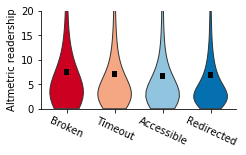

In [79]:
f, ax = pl.subplots( 1, 1, figsize=(3.5, 1.8) )

# let's make sure the order is maintained:
data = [scores[4], scores[-1], scores[1], scores[3]]

parts = ax.violinplot( data, [0,1,2,3], showmeans=False, showmedians=False, 
                              showextrema=False, widths=0.7, points=500 )

j = 0
for pc in parts['bodies']:
    pc.set_facecolor(colors_list[j])
    pc.set_edgecolor( (0.2,0.2,0.2) )
    pc.set_edgecolors( (0.2,0.2,0.2) )
    pc.set_alpha(1)
    j += 1
    

def buttpos(x): return [x-0.05,x+0.05]
for j in range(4):
    pl.plot(buttpos(j), [np.mean(data[j])]*2, color="k", 
                linewidth=6, solid_capstyle="butt", zorder=4)

# for j in range(4):
#     ax.text( j-0.4, -2, 'n='+str(len(data[j])), fontsize=7 )

ax.set_ylim(0,20)
ax.set_ylabel('Altmetric readership')

ax.set_xlabel('')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels( ['Broken','Timeout','Accessible','Redirected'], rotation=-25 )

simpleaxis(ax)

pl.savefig('Figure_1_panels/Altmetric numReaders vs status.pdf')

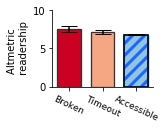

In [80]:
f, ax = pl.subplots( 1, 1, figsize=(1.8, 1.4) )

# let's make sure the order is maintained:
data = [ np.mean(scores[4]), np.mean(scores[-1]), np.mean(scores[1] + scores[3]) ]
vardata = [ np.std(scores[4])/np.sqrt(len(scores[4])), 
           np.std(scores[-1])/np.sqrt(len(scores[-1])), 
           np.std(scores[1] + scores[3])/np.sqrt(len(scores[1] + scores[3])) ]

colors=[(1.0,0.2,0.1),(1.0,0.6,0.2),(0.5,1.0,0.5)]
pl.bar( [0,1,2], data, 0.7, yerr=vardata, color=colors_list, 
           edgecolor=[(0.2,0.2,0.2)]*3, lw=1.3, capsize=8 )

pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color=colors_list[2:], hatch="//",
           edgecolor=[(0.1,0.4,1.0)]*3, lw=1.5, capsize=8 )
pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color='none',
           edgecolor=[(0.0,0.0,0.0)]*3, lw=1.5, capsize=8 )


ax.set_ylim(0,10)
ax.set_ylabel('Altmetric \n readership')

ax.set_xlabel('')
ax.set_xlim(-0.5,2.5)
ax.set_xticks([0,1,2])
ax.set_xticklabels( ['Broken','Timeout','Accessible'], 
                       rotation=-25, fontsize=9)

simpleaxis(ax)

pl.savefig('Figure_1_panels/Altmetric numReaders vs status - barplot.pdf')

In [81]:
lists = scores[-1]+scores[4]+scores[1]+scores[3]
categories = len(scores[-1])*[-1]+len(scores[4])*[4]+len(scores[1]+scores[3])*[1]

mc = MultiComparison(lists, categories)
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  -1     1    -0.3361  -0.9914 0.3193 False 
  -1     4     0.3815  -0.6195 1.3825 False 
  1      4     0.7176   -0.119 1.5542 False 
--------------------------------------------
[-1  1  4]


## Altmetric citation

In [82]:
scores = {}
for status in  [1,3,-1,4]:
    scores[status] = []

for index, row in uniqueLinks.iterrows():
    if row.id in dictAltmetric.keys():
        numYears = (year - 2003)
        scores[ row.status ].append( dictAltmetric[row.id]['cited'] / numYears )

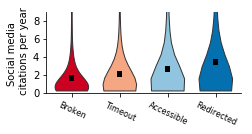

In [83]:
f, ax = pl.subplots( 1, 1, figsize=(3.5, 1.5) )

# let's make sure the order is maintained:
data = [scores[4], scores[-1], scores[1], scores[3]]

parts = ax.violinplot( data, [0,1,2,3], showmeans=False, showmedians=False, 
                              showextrema=False, widths=0.7, points=500 )

j = 0
for pc in parts['bodies']:
    pc.set_facecolor(colors_list[j])
    pc.set_edgecolor( (0.2,0.2,0.2) )
    pc.set_edgecolors( (0.2,0.2,0.2) )
    pc.set_alpha(1)
    j += 1
    

def buttpos(x): return [x-0.05,x+0.05]
for j in range(4):
    pl.plot(buttpos(j), [np.mean(data[j])]*2, color="k", 
                linewidth=6, solid_capstyle="butt", zorder=4)

# for j in range(4):
#     ax.text( j-0.4, -2, 'n='+str(len(data[j])), fontsize=7 )

ax.set_ylim(0,9)
ax.set_ylabel('Social media \n citations per year')
ax.set_yticks([0,2,4,6,8])

ax.set_xlabel('')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels( ['Broken','Timeout','Accessible','Redirected'], 
                       rotation=-25, fontsize=8 )

simpleaxis(ax)

pl.savefig('Figure_1_panels/Altmetric Cited vs status.pdf')

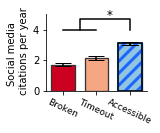

In [84]:
f, ax = pl.subplots( 1, 1, figsize=(1.8, 1.4) )

# let's make sure the order is maintained:
data = [ np.mean(scores[4]), np.mean(scores[-1]), np.mean(scores[1] + scores[3]) ]
vardata = [ np.std(scores[4])/np.sqrt(len(scores[4])), 
           np.std(scores[-1])/np.sqrt(len(scores[-1])), 
           np.std(scores[1] + scores[3])/np.sqrt(len(scores[1] + scores[3])) ]

colors=[(1.0,0.2,0.1),(1.0,0.6,0.2),(0.5,1.0,0.5)]
pl.bar( [0,1,2], data, 0.7, yerr=vardata, color=colors_list, 
           edgecolor=[(0.2,0.2,0.2)]*3, lw=1.3, capsize=8 )

pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color=colors_list[2:], hatch="//",
           edgecolor=[(0.1,0.4,1.0)]*3, lw=1.5, capsize=8 )
pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color='none',
           edgecolor=[(0.0,0.0,0.0)]*3, lw=1.5, capsize=8 )


ax.set_ylim(0,5)
ax.set_ylabel('Social media \n citations per year')

ax.set_xlabel('')
ax.set_xlim(-0.5,2.5)
ax.set_xticks([0,1,2])
ax.set_xticklabels( ['Broken','Timeout','Accessible'], 
                       rotation=-25, fontsize=9)

ax.text(1.3, 4.7, '*', fontsize=12)
ax.plot([2,2,0.5,0.5], [4,4.7,4.7,4], color='k', lw=1.5)
ax.plot([0,1], [4,4], color='k', lw=1.5)

simpleaxis(ax)

pl.savefig('Figure_1_panels/Altmetric Cited vs status - barplot.pdf')

In [85]:
lists = scores[-1]+scores[4]+scores[1]+scores[3]
categories = len(scores[-1])*[-1]+len(scores[4])*[4]+len(scores[1]+scores[3])*[1]

from scipy.stats.mstats import kruskalwallis
print(kruskalwallis(scores[-1],scores[4],scores[1],scores[3]))

mc = MultiComparison(lists, categories)
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

KruskalResult(statistic=441.91001060841415, pvalue=1.8452145962513046e-95)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  -1     1     0.9539   0.4228  1.4849  True 
  -1     4     -0.457  -1.2682  0.3542 False 
  1      4    -1.4109  -2.0888 -0.7329  True 
---------------------------------------------
[-1  1  4]
